# Randomly subsample genome

How does accuracy vary with genome completeness, for each condition/model?

Data:

- 10 genomes for each condition
- Even spacing across predicted values
- Identified in another notebook



How does subsampling work?
- Takes random % of each contig
- Take random % of proteins


In [1]:
import datetime
import sys
from pathlib import Path
import json 
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import pandas as pd
import sys
sys.path.append("../")
from genome_spot.helpers import rename_condition_to_variable, load_train_and_test_sets
from genome_spot.genome_spot import GenomeSPOT
from genome_spot.bioinformatics.genome import measure_genome_features
ROOT_DIR = str(Path().resolve().parent)
plt.rcParams['svg.fonttype'] = 'none'

sys.path.append('../')
plt.style.use(f'{ROOT_DIR}/notebooks/project.mplstyle')

units = {
    'temperature' : u'\N{DEGREE SIGN}C',
    'ph' : 'pH',
    'salinity' : '% NaCl',
    'oxygen' : 'Prob.'
}

plot_formats = {
    'oxygen' : 'Oxygen',
    'temperature' : 'Temperature',
    'ph' : 'pH',
    'salinity' : 'Salinity',
    'temperature_optimum' : 'Temperature, Optimum ',
    'ph_optimum' : 'pH, Optimum',
    'salinity_optimum' : 'Salinity, Optimum',
    'temperature_min' : 'Temperature, Minimum',
    'salinity_min' : 'Salinity, Minimum',
    'ph_min' : 'pH, Minimum',
    'temperature_max' : 'Temperature, Maximum',
    'salinity_max' : 'Salinity, Maximum',
    'ph_max' : 'pH, Maximum',
}
measure_genome_features?

Signature: measure_genome_features(faa_path: str, fna_path: str, subsample=1) -> Dict[str, dict]
Docstring: Measure features from the provided genome files
File:      ~/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/genome_spot/bioinformatics/genome.py
Type:      function

## Get genomes to test

In [2]:
sers = []
for tsv in glob(f"../data/predictions/*.predictions.tsv"):
    try:
        predictions_df = pd.read_csv(tsv, sep='\t', index_col=0)
        accession = tsv.split('/')[-1][:-len('.predictions.tsv')]
        ser = predictions_df['value']
        ser.name = accession
        sers.append(ser)
    except:
        pass

predictions_df = pd.concat(sers,axis=1).T
predictions_df

target,oxygen,ph_max,ph_min,ph_optimum,salinity_max,salinity_min,salinity_optimum,temperature_max,temperature_min,temperature_optimum
GCA_900537995,0.000341,9.615705,6.009947,7.709260,6.618236,2.428143,4.260767,47.892852,23.642944,37.969341
GCA_010994245,0.983036,9.819209,5.389993,7.427742,1.484435,0.000000,0.000000,36.267892,11.064024,27.316905
GCA_014642875,0.975182,8.334303,4.938631,6.501141,4.977786,0.000000,1.099851,37.840509,11.848390,27.968164
GCA_025821665,0.958858,9.012780,4.841343,6.778810,5.564799,1.882745,3.860884,41.353620,20.120449,33.360916
GCA_002162375,0.939177,9.854402,6.132489,7.951707,7.873819,0.756093,3.183162,35.601662,10.543946,28.240999
...,...,...,...,...,...,...,...,...,...,...
GCA_001467525,0.909246,9.711974,5.662876,7.532405,2.845951,0.000000,1.806156,35.455794,18.624838,28.251180
GCA_900169535,0.767102,9.109150,5.541656,7.308866,8.169874,0.000000,2.037091,50.490530,23.112947,40.097188
GCA_003967355,0.885212,9.003890,4.905388,6.742576,8.486547,1.832436,3.862802,39.538797,17.057287,30.639582
GCA_009829925,0.919213,8.866020,5.121014,6.898838,4.797164,0.000000,0.000000,43.375592,14.966473,34.387047


In [3]:
from collections import defaultdict
PATH_TO_HOLDOUTS = '../data/holdouts/'

genomes_to_test = defaultdict(list)
conditions = [ 'oxygen', 'temperature', 'salinity', 'ph', ]
for condition in conditions:
    target = rename_condition_to_variable(condition)
    train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
    X = predictions_df.reindex(train_set)[target].dropna()
    value_bounds = [value for value in np.linspace(X.min(), X.max(),10)]
    #for value in np.linspace(X.min(),X.max(),20):
    print(np.percentile(X, [int(i) for i in np.linspace(0, 100, 20)]))
    for value in np.percentile(X, [int(i) for i in np.linspace(0, 100, 20)]):
        closest_index = X.index[np.argmin(np.abs(X - value))]
        genomes_to_test[target].append(closest_index)
        
genomes_to_test

[3.59875654e-07 3.19355497e-04 1.41148028e-03 3.67601434e-03
 1.15709010e-02 2.20224835e-02 4.94046490e-02 1.90054274e-01
 6.05662426e-01 7.77070639e-01 8.74321508e-01 9.15566930e-01
 9.41146905e-01 9.56717262e-01 9.67992316e-01 9.75646117e-01
 9.83070370e-01 9.87274227e-01 9.91852007e-01 9.99853545e-01]
[15.96093793 21.54935727 23.32475496 24.56460795 25.7366653  26.65359067
 27.47505347 28.12872971 28.92537744 29.58882892 30.30106375 31.23621623
 32.42638183 33.37764142 34.58239494 36.24316204 39.16750034 44.05330613
 53.98058051 94.36394687]
[ 0.          0.20561604  0.75502855  1.35860045  1.79474212  2.01744009
  2.34328597  2.74000391  3.1027906   3.40703826  3.63017123  3.88118704
  4.16085474  4.47728387  4.9560455   5.98957326  7.32649017 17.08668392
 18.89263038 22.20022326]
[2.89842423 5.45947351 5.88776655 6.22002274 6.5908306  6.80604691
 6.92530573 7.02374339 7.11737273 7.22881881 7.30206345 7.40634643
 7.53338757 7.61070038 7.74237462 7.87785681 8.07337393 8.21950488
 8.

defaultdict(list,
            {'oxygen': ['GCA_004310395',
              'GCA_015163485',
              'GCA_001643775',
              'GCA_003814835',
              'GCA_900115655',
              'GCA_000745975',
              'GCA_013389365',
              'GCA_000373185',
              'GCA_013201705',
              'GCA_001544015',
              'GCA_011927685',
              'GCA_001029435',
              'GCA_900447645',
              'GCA_002163585',
              'GCA_003177275',
              'GCA_014648315',
              'GCA_014643175',
              'GCA_003788585',
              'GCA_014653155',
              'GCA_900660465'],
             'temperature_optimum': ['GCA_014645015',
              'GCA_004340665',
              'GCA_000422265',
              'GCA_003149515',
              'GCA_001043175',
              'GCA_000429845',
              'GCA_014203705',
              'GCA_900105015',
              'GCA_000521505',
              'GCA_014201785',
              'GCA

In [4]:
from genome_spot.taxonomy.taxonomy import TaxonomyGTDB
taxonomy = TaxonomyGTDB()
taxonomy_dict = taxonomy.taxonomy_dict


In [5]:
from collections import Counter

for target, genomes in genomes_to_test.items():
    species = []
    for genome in genomes:
        species.extend([taxonomy.taxonomy_dict[genome][-1]])
    print([k for k, v in Counter(species).items() if v > 1])

[]
[]
[]
[]


## Subsample

In [6]:
subsample_portions = np.linspace(0.1, 1., 19)
subsample_portions

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [7]:
targets =  [ 'oxygen', 'temperature_optimum', 'temperature_max', 'temperature_min', 'salinity_optimum', 'salinity_max', 'salinity_min', 'ph_optimum', 'ph_max', 'ph_min', ]

In [8]:
subsample_portions

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [9]:
for target, genomes in genomes_to_test.items():
    for genome in genomes:
        contig_filepath = glob(f"{ROOT_DIR}/data/genomes/genbank/*/*/{genome}.*.fna.gz")[0]
        protein_filepath = glob(f"{ROOT_DIR}/data/genomes/genbank/*/*/{genome}.*.faa.gz")[0]
        prefix = contig_filepath.split('/')[-1].split('.')[0]

        print(datetime.datetime.now(), target, genome)
        
        subsample_predictions = {}
        for subsample in subsample_portions[::-1]:
            # try:
            #print(subsample)
            genome_features = measure_genome_features(faa_path=protein_filepath, fna_path=contig_filepath, subsample=subsample)
            predictions = GenomeSPOT().predict_from_genome(genome_features, path_to_models='../models/')
            subsample_predictions[subsample] = {k : d.get('value', np.nan) for k, d in predictions.items()}
            
            # get probabilities for oxygen 
            #{k : d.get('value', np.nan) for k, d in predictions.items()}
            value = predictions.get('oxygen', {}).get('value', '')
            prob = predictions.get('oxygen', {}).get('error', np.nan)
            
            if value == 'tolerant':
                value = prob
            else:
                value = 1 - prob
            subsample_predictions[subsample]['oxygen'] = value
        # except:
            #     print(subsample, 'FAILED')
            #     subsample_predictions[subsample] = {k : np.nan for k in targets}

        filepath = f'../data/subsample_experiment/{prefix}.predictions.json'
        json.dump(subsample_predictions, open(filepath, 'w'))

2024-03-18 09:19:28 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_004310395.1/GCA_004310395.1_ASM431039v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_004310395.1/GCA_004310395.1_ASM431039v1_protein.faa.gz
2024-03-18 09:19:28 INFO GCA_004310395.1_ASM431039v1_genomic.fna.gz: Identifying protein localization


2024-03-18 09:19:28.454875 oxygen GCA_004310395


2024-03-18 09:19:29 INFO GCA_004310395.1_ASM431039v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:19:29 INFO GCA_004310395.1_ASM431039v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:19:29 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_004310395.1/GCA_004310395.1_ASM431039v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_004310395.1/GCA_004310395.1_ASM431039v1_protein.faa.gz
2024-03-18 09:19:29 INFO GCA_004310395.1_ASM431039v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:19:30 INFO GCA_004310395.1_ASM431039v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:19:30 INFO GCA_004310395.1_ASM431039v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:19:30 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_004310

2024-03-18 09:19:41.772785 oxygen GCA_015163485


2024-03-18 09:19:42 INFO GCA_015163485.1_ASM1516348v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:19:43 INFO GCA_015163485.1_ASM1516348v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:19:43 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_015163485.1/GCA_015163485.1_ASM1516348v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_015163485.1/GCA_015163485.1_ASM1516348v1_protein.faa.gz
2024-03-18 09:19:43 INFO GCA_015163485.1_ASM1516348v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:19:43 INFO GCA_015163485.1_ASM1516348v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:19:44 INFO GCA_015163485.1_ASM1516348v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:19:44 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA

2024-03-18 09:20:02.207041 oxygen GCA_001643775


2024-03-18 09:20:02 INFO GCA_001643775.1_ASM164377v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:20:03 INFO GCA_001643775.1_ASM164377v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:20:03 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001643775.1/GCA_001643775.1_ASM164377v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001643775.1/GCA_001643775.1_ASM164377v1_protein.faa.gz
2024-03-18 09:20:03 INFO GCA_001643775.1_ASM164377v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:20:04 INFO GCA_001643775.1_ASM164377v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:20:04 INFO GCA_001643775.1_ASM164377v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:20:04 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001

2024-03-18 09:20:22.049467 oxygen GCA_003814835


2024-03-18 09:20:22 INFO GCA_003814835.1_ASM381483v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:20:23 INFO GCA_003814835.1_ASM381483v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:20:23 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_003814835.1/GCA_003814835.1_ASM381483v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_003814835.1/GCA_003814835.1_ASM381483v1_protein.faa.gz
2024-03-18 09:20:23 INFO GCA_003814835.1_ASM381483v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:20:23 INFO GCA_003814835.1_ASM381483v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:20:24 INFO GCA_003814835.1_ASM381483v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:20:24 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_003814

2024-03-18 09:20:40.121094 oxygen GCA_900115655


2024-03-18 09:20:41 INFO GCA_900115655.1_IMG-taxon_2595698241_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:20:41 INFO GCA_900115655.1_IMG-taxon_2595698241_annotated_assembly_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:20:41 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900115655.1/GCA_900115655.1_IMG-taxon_2595698241_annotated_assembly_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900115655.1/GCA_900115655.1_IMG-taxon_2595698241_annotated_assembly_protein.faa.gz
2024-03-18 09:20:41 INFO GCA_900115655.1_IMG-taxon_2595698241_annotated_assembly_genomic.fna.gz: Identifying protein localization
2024-03-18 09:20:42 INFO GCA_900115655.1_IMG-taxon_2595698241_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:20:43 INFO GCA_900115655.1_IMG-taxon_2595698241_annotated_assembly_

2024-03-18 09:21:04.084922 oxygen GCA_000745975


2024-03-18 09:21:05 INFO GCA_000745975.1_ASM74597v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:21:06 INFO GCA_000745975.1_ASM74597v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:21:06 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000745975.1/GCA_000745975.1_ASM74597v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000745975.1/GCA_000745975.1_ASM74597v1_protein.faa.gz
2024-03-18 09:21:06 INFO GCA_000745975.1_ASM74597v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:21:08 INFO GCA_000745975.1_ASM74597v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:21:09 INFO GCA_000745975.1_ASM74597v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:21:09 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000745975.

2024-03-18 09:21:44.805588 oxygen GCA_013389365


2024-03-18 09:21:46 INFO GCA_013389365.1_ASM1338936v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:21:47 INFO GCA_013389365.1_ASM1338936v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:21:47 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_013389365.1/GCA_013389365.1_ASM1338936v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_013389365.1/GCA_013389365.1_ASM1338936v1_protein.faa.gz
2024-03-18 09:21:47 INFO GCA_013389365.1_ASM1338936v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:21:48 INFO GCA_013389365.1_ASM1338936v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:21:49 INFO GCA_013389365.1_ASM1338936v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:21:49 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-18 09:22:23.286673 oxygen GCA_000373185


2024-03-18 09:22:24 INFO GCA_000373185.1_ASM37318v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:22:25 INFO GCA_000373185.1_ASM37318v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:22:25 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000373185.1/GCA_000373185.1_ASM37318v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000373185.1/GCA_000373185.1_ASM37318v1_protein.faa.gz
2024-03-18 09:22:25 INFO GCA_000373185.1_ASM37318v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:22:26 INFO GCA_000373185.1_ASM37318v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:22:27 INFO GCA_000373185.1_ASM37318v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:22:27 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000373185.

2024-03-18 09:22:53.446632 oxygen GCA_013201705


2024-03-18 09:22:54 INFO GCA_013201705.1_ASM1320170v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:22:54 INFO GCA_013201705.1_ASM1320170v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:22:54 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_013201705.1/GCA_013201705.1_ASM1320170v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_013201705.1/GCA_013201705.1_ASM1320170v1_protein.faa.gz
2024-03-18 09:22:54 INFO GCA_013201705.1_ASM1320170v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:22:55 INFO GCA_013201705.1_ASM1320170v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:22:56 INFO GCA_013201705.1_ASM1320170v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:22:56 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-18 09:23:17.449811 oxygen GCA_001544015


2024-03-18 09:23:18 INFO GCA_001544015.1_ASM154401v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:23:19 INFO GCA_001544015.1_ASM154401v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:23:19 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001544015.1/GCA_001544015.1_ASM154401v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001544015.1/GCA_001544015.1_ASM154401v1_protein.faa.gz
2024-03-18 09:23:19 INFO GCA_001544015.1_ASM154401v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:23:21 INFO GCA_001544015.1_ASM154401v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:23:21 INFO GCA_001544015.1_ASM154401v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:23:22 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001

2024-03-18 09:23:54.354864 oxygen GCA_011927685


2024-03-18 09:23:55 INFO GCA_011927685.1_ASM1192768v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:23:56 INFO GCA_011927685.1_ASM1192768v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:23:56 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_011927685.1/GCA_011927685.1_ASM1192768v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_011927685.1/GCA_011927685.1_ASM1192768v1_protein.faa.gz
2024-03-18 09:23:56 INFO GCA_011927685.1_ASM1192768v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:23:58 INFO GCA_011927685.1_ASM1192768v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:23:59 INFO GCA_011927685.1_ASM1192768v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:23:59 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-18 09:24:36.283958 oxygen GCA_001029435


2024-03-18 09:24:38 INFO GCA_001029435.1_ASM102943v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:24:39 INFO GCA_001029435.1_ASM102943v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:24:39 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001029435.1/GCA_001029435.1_ASM102943v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001029435.1/GCA_001029435.1_ASM102943v1_protein.faa.gz
2024-03-18 09:24:39 INFO GCA_001029435.1_ASM102943v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:24:40 INFO GCA_001029435.1_ASM102943v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:24:41 INFO GCA_001029435.1_ASM102943v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:24:42 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001

2024-03-18 09:25:22.304786 oxygen GCA_900447645


2024-03-18 09:25:24 INFO GCA_900447645.1_39130_A01_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:25:25 INFO GCA_900447645.1_39130_A01_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:25:25 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900447645.1/GCA_900447645.1_39130_A01_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900447645.1/GCA_900447645.1_39130_A01_protein.faa.gz
2024-03-18 09:25:25 INFO GCA_900447645.1_39130_A01_genomic.fna.gz: Identifying protein localization
2024-03-18 09:25:26 INFO GCA_900447645.1_39130_A01_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:25:27 INFO GCA_900447645.1_39130_A01_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:25:27 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900447645.1/GCA_9

2024-03-18 09:26:07.470190 oxygen GCA_002163585


2024-03-18 09:26:09 INFO GCA_002163585.1_ASM216358v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:26:10 INFO GCA_002163585.1_ASM216358v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:26:10 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002163585.1/GCA_002163585.1_ASM216358v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002163585.1/GCA_002163585.1_ASM216358v1_protein.faa.gz
2024-03-18 09:26:10 INFO GCA_002163585.1_ASM216358v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:26:11 INFO GCA_002163585.1_ASM216358v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:26:12 INFO GCA_002163585.1_ASM216358v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:26:12 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002

2024-03-18 09:26:49.739352 oxygen GCA_003177275


2024-03-18 09:26:50 INFO GCA_003177275.1_ASM317727v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:26:51 INFO GCA_003177275.1_ASM317727v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:26:51 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003177275.1/GCA_003177275.1_ASM317727v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003177275.1/GCA_003177275.1_ASM317727v1_protein.faa.gz
2024-03-18 09:26:51 INFO GCA_003177275.1_ASM317727v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:26:52 INFO GCA_003177275.1_ASM317727v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:26:52 INFO GCA_003177275.1_ASM317727v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:26:52 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-18 09:27:13.639872 oxygen GCA_014648315


2024-03-18 09:27:15 INFO GCA_014648315.1_ASM1464831v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:27:16 INFO GCA_014648315.1_ASM1464831v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:27:16 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014648315.1/GCA_014648315.1_ASM1464831v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014648315.1/GCA_014648315.1_ASM1464831v1_protein.faa.gz
2024-03-18 09:27:16 INFO GCA_014648315.1_ASM1464831v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:27:17 INFO GCA_014648315.1_ASM1464831v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:27:18 INFO GCA_014648315.1_ASM1464831v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:27:18 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-18 09:27:55.773189 oxygen GCA_014643175


2024-03-18 09:27:57 INFO GCA_014643175.1_ASM1464317v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:27:57 INFO GCA_014643175.1_ASM1464317v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:27:57 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014643175.1/GCA_014643175.1_ASM1464317v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014643175.1/GCA_014643175.1_ASM1464317v1_protein.faa.gz
2024-03-18 09:27:57 INFO GCA_014643175.1_ASM1464317v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:27:59 INFO GCA_014643175.1_ASM1464317v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:27:59 INFO GCA_014643175.1_ASM1464317v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:27:59 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-18 09:28:30.090955 oxygen GCA_003788585


2024-03-18 09:28:31 INFO GCA_003788585.1_ASM378858v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:28:31 INFO GCA_003788585.1_ASM378858v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:28:31 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003788585.1/GCA_003788585.1_ASM378858v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003788585.1/GCA_003788585.1_ASM378858v1_protein.faa.gz
2024-03-18 09:28:31 INFO GCA_003788585.1_ASM378858v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:28:33 INFO GCA_003788585.1_ASM378858v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:28:33 INFO GCA_003788585.1_ASM378858v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:28:33 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-18 09:29:00.464136 oxygen GCA_014653155


2024-03-18 09:29:01 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:29:02 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:29:02 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014653155.1/GCA_014653155.1_ASM1465315v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014653155.1/GCA_014653155.1_ASM1465315v1_protein.faa.gz
2024-03-18 09:29:02 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:29:04 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:29:05 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:29:05 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-18 09:29:39.231291 oxygen GCA_900660465


2024-03-18 09:29:39 INFO GCA_900660465.1_50648_A01-3_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:29:39 INFO GCA_900660465.1_50648_A01-3_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:29:39 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900660465.1/GCA_900660465.1_50648_A01-3_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900660465.1/GCA_900660465.1_50648_A01-3_protein.faa.gz
2024-03-18 09:29:39 INFO GCA_900660465.1_50648_A01-3_genomic.fna.gz: Identifying protein localization
2024-03-18 09:29:40 INFO GCA_900660465.1_50648_A01-3_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:29:40 INFO GCA_900660465.1_50648_A01-3_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:29:40 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900

2024-03-18 09:29:47.742248 temperature_optimum GCA_014645015


2024-03-18 09:29:48 INFO GCA_014645015.1_ASM1464501v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:29:49 INFO GCA_014645015.1_ASM1464501v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:29:49 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014645015.1/GCA_014645015.1_ASM1464501v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014645015.1/GCA_014645015.1_ASM1464501v1_protein.faa.gz
2024-03-18 09:29:49 INFO GCA_014645015.1_ASM1464501v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:29:50 INFO GCA_014645015.1_ASM1464501v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:29:51 INFO GCA_014645015.1_ASM1464501v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:29:51 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-18 09:30:17.476459 temperature_optimum GCA_004340665


2024-03-18 09:30:19 INFO GCA_004340665.1_ASM434066v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:30:20 INFO GCA_004340665.1_ASM434066v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:30:20 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_004340665.1/GCA_004340665.1_ASM434066v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_004340665.1/GCA_004340665.1_ASM434066v1_protein.faa.gz
2024-03-18 09:30:20 INFO GCA_004340665.1_ASM434066v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:30:22 INFO GCA_004340665.1_ASM434066v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:30:23 INFO GCA_004340665.1_ASM434066v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:30:23 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_004

2024-03-18 09:31:04.333172 temperature_optimum GCA_000422265


2024-03-18 09:31:05 INFO GCA_000422265.1_ASM42226v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:31:06 INFO GCA_000422265.1_ASM42226v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:31:06 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000422265.1/GCA_000422265.1_ASM42226v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000422265.1/GCA_000422265.1_ASM42226v1_protein.faa.gz
2024-03-18 09:31:06 INFO GCA_000422265.1_ASM42226v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:31:07 INFO GCA_000422265.1_ASM42226v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:31:07 INFO GCA_000422265.1_ASM42226v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:31:07 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000422265.

2024-03-18 09:31:32.964445 temperature_optimum GCA_003149515


2024-03-18 09:31:34 INFO GCA_003149515.1_ASM314951v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:31:35 INFO GCA_003149515.1_ASM314951v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:31:35 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003149515.1/GCA_003149515.1_ASM314951v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003149515.1/GCA_003149515.1_ASM314951v1_protein.faa.gz
2024-03-18 09:31:35 INFO GCA_003149515.1_ASM314951v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:31:37 INFO GCA_003149515.1_ASM314951v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:31:38 INFO GCA_003149515.1_ASM314951v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:31:38 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-18 09:32:18.032463 temperature_optimum GCA_001043175


2024-03-18 09:32:19 INFO GCA_001043175.1_ASM104317v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:32:20 INFO GCA_001043175.1_ASM104317v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:32:20 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001043175.1/GCA_001043175.1_ASM104317v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001043175.1/GCA_001043175.1_ASM104317v1_protein.faa.gz
2024-03-18 09:32:20 INFO GCA_001043175.1_ASM104317v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:32:21 INFO GCA_001043175.1_ASM104317v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:32:22 INFO GCA_001043175.1_ASM104317v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:32:22 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001

2024-03-18 09:32:54.935293 temperature_optimum GCA_000429845


2024-03-18 09:32:56 INFO GCA_000429845.1_ASM42984v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:32:57 INFO GCA_000429845.1_ASM42984v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:32:57 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000429845.1/GCA_000429845.1_ASM42984v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000429845.1/GCA_000429845.1_ASM42984v1_protein.faa.gz
2024-03-18 09:32:57 INFO GCA_000429845.1_ASM42984v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:32:59 INFO GCA_000429845.1_ASM42984v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:33:00 INFO GCA_000429845.1_ASM42984v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:33:00 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000429845.

2024-03-18 09:33:37.970887 temperature_optimum GCA_014203705


2024-03-18 09:33:40 INFO GCA_014203705.1_ASM1420370v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:33:42 INFO GCA_014203705.1_ASM1420370v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:33:42 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014203705.1/GCA_014203705.1_ASM1420370v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014203705.1/GCA_014203705.1_ASM1420370v1_protein.faa.gz
2024-03-18 09:33:42 INFO GCA_014203705.1_ASM1420370v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:33:45 INFO GCA_014203705.1_ASM1420370v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:33:47 INFO GCA_014203705.1_ASM1420370v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:33:47 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-18 09:34:55.576270 temperature_optimum GCA_900105015


2024-03-18 09:34:56 INFO GCA_900105015.1_IMG-taxon_2634166153_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:34:56 INFO GCA_900105015.1_IMG-taxon_2634166153_annotated_assembly_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:34:56 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900105015.1/GCA_900105015.1_IMG-taxon_2634166153_annotated_assembly_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900105015.1/GCA_900105015.1_IMG-taxon_2634166153_annotated_assembly_protein.faa.gz
2024-03-18 09:34:56 INFO GCA_900105015.1_IMG-taxon_2634166153_annotated_assembly_genomic.fna.gz: Identifying protein localization
2024-03-18 09:34:57 INFO GCA_900105015.1_IMG-taxon_2634166153_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:34:57 INFO GCA_900105015.1_IMG-taxon_2634166153_annotated_assembly_

2024-03-18 09:35:14.295001 temperature_optimum GCA_000521505


2024-03-18 09:35:15 INFO GCA_000521505.1_ASM52150v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:35:17 INFO GCA_000521505.1_ASM52150v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:35:17 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000521505.1/GCA_000521505.1_ASM52150v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000521505.1/GCA_000521505.1_ASM52150v1_protein.faa.gz
2024-03-18 09:35:17 INFO GCA_000521505.1_ASM52150v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:35:18 INFO GCA_000521505.1_ASM52150v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:35:19 INFO GCA_000521505.1_ASM52150v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:35:19 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000521505.

2024-03-18 09:35:57.587306 temperature_optimum GCA_014201785


2024-03-18 09:35:58 INFO GCA_014201785.1_ASM1420178v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:35:59 INFO GCA_014201785.1_ASM1420178v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:35:59 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014201785.1/GCA_014201785.1_ASM1420178v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014201785.1/GCA_014201785.1_ASM1420178v1_protein.faa.gz
2024-03-18 09:35:59 INFO GCA_014201785.1_ASM1420178v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:36:00 INFO GCA_014201785.1_ASM1420178v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:36:01 INFO GCA_014201785.1_ASM1420178v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:36:01 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-18 09:36:27.959905 temperature_optimum GCA_002925845


2024-03-18 09:36:29 INFO GCA_002925845.1_ASM292584v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:36:30 INFO GCA_002925845.1_ASM292584v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:36:30 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002925845.1/GCA_002925845.1_ASM292584v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002925845.1/GCA_002925845.1_ASM292584v1_protein.faa.gz
2024-03-18 09:36:30 INFO GCA_002925845.1_ASM292584v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:36:31 INFO GCA_002925845.1_ASM292584v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:36:32 INFO GCA_002925845.1_ASM292584v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:36:32 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002

2024-03-18 09:37:06.697463 temperature_optimum GCA_024753215


2024-03-18 09:37:08 INFO GCA_024753215.1_ASM2475321v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:37:09 INFO GCA_024753215.1_ASM2475321v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:37:09 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_024753215.1/GCA_024753215.1_ASM2475321v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_024753215.1/GCA_024753215.1_ASM2475321v1_protein.faa.gz
2024-03-18 09:37:09 INFO GCA_024753215.1_ASM2475321v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:37:11 INFO GCA_024753215.1_ASM2475321v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:37:12 INFO GCA_024753215.1_ASM2475321v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:37:12 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-18 09:37:55.121993 temperature_optimum GCA_008802405


2024-03-18 09:37:57 INFO GCA_008802405.1_ASM880240v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:37:58 INFO GCA_008802405.1_ASM880240v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:37:58 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_008802405.1/GCA_008802405.1_ASM880240v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_008802405.1/GCA_008802405.1_ASM880240v1_protein.faa.gz
2024-03-18 09:37:58 INFO GCA_008802405.1_ASM880240v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:37:59 INFO GCA_008802405.1_ASM880240v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:38:00 INFO GCA_008802405.1_ASM880240v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:38:00 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_008

2024-03-18 09:38:41.492070 temperature_optimum GCA_003696285


2024-03-18 09:38:43 INFO GCA_003696285.1_ASM369628v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:38:44 INFO GCA_003696285.1_ASM369628v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:38:44 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003696285.1/GCA_003696285.1_ASM369628v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003696285.1/GCA_003696285.1_ASM369628v1_protein.faa.gz
2024-03-18 09:38:44 INFO GCA_003696285.1_ASM369628v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:38:45 INFO GCA_003696285.1_ASM369628v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:38:46 INFO GCA_003696285.1_ASM369628v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:38:46 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-18 09:39:22.835831 temperature_optimum GCA_016722785


2024-03-18 09:39:25 INFO GCA_016722785.1_ASM1672278v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:39:26 INFO GCA_016722785.1_ASM1672278v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:39:26 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_016722785.1/GCA_016722785.1_ASM1672278v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_016722785.1/GCA_016722785.1_ASM1672278v1_protein.faa.gz
2024-03-18 09:39:26 INFO GCA_016722785.1_ASM1672278v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:39:28 INFO GCA_016722785.1_ASM1672278v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:39:30 INFO GCA_016722785.1_ASM1672278v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:39:30 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-18 09:40:22.169008 temperature_optimum GCA_000423525


2024-03-18 09:40:23 INFO GCA_000423525.1_ASM42352v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:40:23 INFO GCA_000423525.1_ASM42352v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:40:23 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000423525.1/GCA_000423525.1_ASM42352v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000423525.1/GCA_000423525.1_ASM42352v1_protein.faa.gz
2024-03-18 09:40:23 INFO GCA_000423525.1_ASM42352v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:40:24 INFO GCA_000423525.1_ASM42352v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:40:25 INFO GCA_000423525.1_ASM42352v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:40:25 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000423525.

2024-03-18 09:40:45.988976 temperature_optimum GCA_001462205


2024-03-18 09:40:47 INFO GCA_001462205.1_HalopeDYS1.0_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:40:47 INFO GCA_001462205.1_HalopeDYS1.0_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:40:48 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_001462205.1/GCA_001462205.1_HalopeDYS1.0_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_001462205.1/GCA_001462205.1_HalopeDYS1.0_protein.faa.gz
2024-03-18 09:40:48 INFO GCA_001462205.1_HalopeDYS1.0_genomic.fna.gz: Identifying protein localization
2024-03-18 09:40:49 INFO GCA_001462205.1_HalopeDYS1.0_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:40:49 INFO GCA_001462205.1_HalopeDYS1.0_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:40:49 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA

2024-03-18 09:41:18.863140 temperature_optimum GCA_009466385


2024-03-18 09:41:20 INFO GCA_009466385.1_ASM946638v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:41:20 INFO GCA_009466385.1_ASM946638v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:41:20 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_009466385.1/GCA_009466385.1_ASM946638v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_009466385.1/GCA_009466385.1_ASM946638v1_protein.faa.gz
2024-03-18 09:41:20 INFO GCA_009466385.1_ASM946638v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:41:22 INFO GCA_009466385.1_ASM946638v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:41:22 INFO GCA_009466385.1_ASM946638v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:41:22 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_009

2024-03-18 09:41:52.045546 temperature_optimum GCA_001552255


2024-03-18 09:41:53 INFO GCA_001552255.1_ASM155225v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:41:54 INFO GCA_001552255.1_ASM155225v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:41:54 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001552255.1/GCA_001552255.1_ASM155225v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001552255.1/GCA_001552255.1_ASM155225v1_protein.faa.gz
2024-03-18 09:41:54 INFO GCA_001552255.1_ASM155225v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:41:55 INFO GCA_001552255.1_ASM155225v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:41:56 INFO GCA_001552255.1_ASM155225v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:41:56 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001

2024-03-18 09:42:28.399475 temperature_optimum GCA_000017945


2024-03-18 09:42:28 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:42:29 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:42:29 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_000017945.1/GCA_000017945.1_ASM1794v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_000017945.1/GCA_000017945.1_ASM1794v1_protein.faa.gz
2024-03-18 09:42:29 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:42:29 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:42:30 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:42:30 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_000017945.1/GCA_0000

2024-03-18 09:42:42.790958 salinity_optimum GCA_000017945


2024-03-18 09:42:43 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:42:43 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:42:43 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_000017945.1/GCA_000017945.1_ASM1794v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_000017945.1/GCA_000017945.1_ASM1794v1_protein.faa.gz
2024-03-18 09:42:43 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:42:44 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:42:44 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:42:44 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_000017945.1/GCA_0000

2024-03-18 09:42:57.423819 salinity_optimum GCA_000429325


2024-03-18 09:42:59 INFO GCA_000429325.1_ASM42932v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:43:00 INFO GCA_000429325.1_ASM42932v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:43:00 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000429325.1/GCA_000429325.1_ASM42932v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000429325.1/GCA_000429325.1_ASM42932v1_protein.faa.gz
2024-03-18 09:43:00 INFO GCA_000429325.1_ASM42932v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:43:01 INFO GCA_000429325.1_ASM42932v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:43:02 INFO GCA_000429325.1_ASM42932v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:43:02 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000429325.

2024-03-18 09:43:41.183429 salinity_optimum GCA_003583925


2024-03-18 09:43:42 INFO GCA_003583925.1_ASM358392v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:43:43 INFO GCA_003583925.1_ASM358392v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:43:43 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003583925.1/GCA_003583925.1_ASM358392v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003583925.1/GCA_003583925.1_ASM358392v1_protein.faa.gz
2024-03-18 09:43:43 INFO GCA_003583925.1_ASM358392v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:43:45 INFO GCA_003583925.1_ASM358392v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:43:46 INFO GCA_003583925.1_ASM358392v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:43:46 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-18 09:44:25.972833 salinity_optimum GCA_003058325


2024-03-18 09:44:28 INFO GCA_003058325.1_ASM305832v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:44:30 INFO GCA_003058325.1_ASM305832v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:44:30 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003058325.1/GCA_003058325.1_ASM305832v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003058325.1/GCA_003058325.1_ASM305832v1_protein.faa.gz
2024-03-18 09:44:30 INFO GCA_003058325.1_ASM305832v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:44:33 INFO GCA_003058325.1_ASM305832v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:44:34 INFO GCA_003058325.1_ASM305832v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:44:34 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-18 09:45:35.544512 salinity_optimum GCA_003284895


2024-03-18 09:45:36 INFO GCA_003284895.1_ASM328489v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:45:37 INFO GCA_003284895.1_ASM328489v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:45:37 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003284895.1/GCA_003284895.1_ASM328489v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003284895.1/GCA_003284895.1_ASM328489v1_protein.faa.gz
2024-03-18 09:45:37 INFO GCA_003284895.1_ASM328489v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:45:39 INFO GCA_003284895.1_ASM328489v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:45:39 INFO GCA_003284895.1_ASM328489v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:45:39 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-18 09:46:09.527925 salinity_optimum GCA_003173715


2024-03-18 09:46:11 INFO GCA_003173715.1_ASM317371v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:46:13 INFO GCA_003173715.1_ASM317371v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:46:13 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003173715.1/GCA_003173715.1_ASM317371v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003173715.1/GCA_003173715.1_ASM317371v1_protein.faa.gz
2024-03-18 09:46:13 INFO GCA_003173715.1_ASM317371v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:46:15 INFO GCA_003173715.1_ASM317371v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:46:16 INFO GCA_003173715.1_ASM317371v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:46:16 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-18 09:47:08.043224 salinity_optimum GCA_016908975


2024-03-18 09:47:10 INFO GCA_016908975.1_ASM1690897v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:47:11 INFO GCA_016908975.1_ASM1690897v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:47:11 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_016908975.1/GCA_016908975.1_ASM1690897v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_016908975.1/GCA_016908975.1_ASM1690897v1_protein.faa.gz
2024-03-18 09:47:11 INFO GCA_016908975.1_ASM1690897v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:47:14 INFO GCA_016908975.1_ASM1690897v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:47:15 INFO GCA_016908975.1_ASM1690897v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:47:15 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-18 09:48:06.080937 salinity_optimum GCA_003012745


2024-03-18 09:48:08 INFO GCA_003012745.1_ASM301274v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:48:09 INFO GCA_003012745.1_ASM301274v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:48:09 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003012745.1/GCA_003012745.1_ASM301274v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003012745.1/GCA_003012745.1_ASM301274v1_protein.faa.gz
2024-03-18 09:48:09 INFO GCA_003012745.1_ASM301274v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:48:11 INFO GCA_003012745.1_ASM301274v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:48:13 INFO GCA_003012745.1_ASM301274v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:48:13 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-18 09:49:04.169278 salinity_optimum GCA_003148665


2024-03-18 09:49:05 INFO GCA_003148665.1_ASM314866v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:49:07 INFO GCA_003148665.1_ASM314866v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:49:07 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003148665.1/GCA_003148665.1_ASM314866v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003148665.1/GCA_003148665.1_ASM314866v1_protein.faa.gz
2024-03-18 09:49:07 INFO GCA_003148665.1_ASM314866v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:49:08 INFO GCA_003148665.1_ASM314866v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:49:09 INFO GCA_003148665.1_ASM314866v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:49:10 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-18 09:49:50.689746 salinity_optimum GCA_007713745


2024-03-18 09:49:53 INFO GCA_007713745.1_ASM771374v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:49:55 INFO GCA_007713745.1_ASM771374v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:49:55 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_007713745.1/GCA_007713745.1_ASM771374v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_007713745.1/GCA_007713745.1_ASM771374v1_protein.faa.gz
2024-03-18 09:49:55 INFO GCA_007713745.1_ASM771374v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:49:58 INFO GCA_007713745.1_ASM771374v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:50:00 INFO GCA_007713745.1_ASM771374v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:50:00 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_007

2024-03-18 09:51:07.435223 salinity_optimum GCA_009811315


2024-03-18 09:51:09 INFO GCA_009811315.1_ASM981131v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:51:10 INFO GCA_009811315.1_ASM981131v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:51:10 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_009811315.1/GCA_009811315.1_ASM981131v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_009811315.1/GCA_009811315.1_ASM981131v1_protein.faa.gz
2024-03-18 09:51:10 INFO GCA_009811315.1_ASM981131v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:51:12 INFO GCA_009811315.1_ASM981131v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:51:12 INFO GCA_009811315.1_ASM981131v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:51:13 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_009

2024-03-18 09:51:52.732637 salinity_optimum GCA_002866825


2024-03-18 09:51:54 INFO GCA_002866825.1_ASM286682v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:51:55 INFO GCA_002866825.1_ASM286682v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:51:55 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002866825.1/GCA_002866825.1_ASM286682v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002866825.1/GCA_002866825.1_ASM286682v1_protein.faa.gz
2024-03-18 09:51:55 INFO GCA_002866825.1_ASM286682v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:51:57 INFO GCA_002866825.1_ASM286682v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:51:57 INFO GCA_002866825.1_ASM286682v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:51:58 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002

2024-03-18 09:52:35.881849 salinity_optimum GCA_001884135


2024-03-18 09:52:37 INFO GCA_001884135.1_ASM188413v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:52:39 INFO GCA_001884135.1_ASM188413v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:52:39 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001884135.1/GCA_001884135.1_ASM188413v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001884135.1/GCA_001884135.1_ASM188413v1_protein.faa.gz
2024-03-18 09:52:39 INFO GCA_001884135.1_ASM188413v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:52:41 INFO GCA_001884135.1_ASM188413v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:52:42 INFO GCA_001884135.1_ASM188413v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:52:42 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001

2024-03-18 09:53:28.921227 salinity_optimum GCA_000423645


2024-03-18 09:53:30 INFO GCA_000423645.1_ASM42364v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:53:31 INFO GCA_000423645.1_ASM42364v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:53:31 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000423645.1/GCA_000423645.1_ASM42364v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000423645.1/GCA_000423645.1_ASM42364v1_protein.faa.gz
2024-03-18 09:53:31 INFO GCA_000423645.1_ASM42364v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:53:32 INFO GCA_000423645.1_ASM42364v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:53:33 INFO GCA_000423645.1_ASM42364v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:53:33 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000423645.

2024-03-18 09:54:04.062751 salinity_optimum GCA_000170835


2024-03-18 09:54:05 INFO GCA_000170835.1_ASM17083v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:54:06 INFO GCA_000170835.1_ASM17083v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:54:06 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000170835.1/GCA_000170835.1_ASM17083v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000170835.1/GCA_000170835.1_ASM17083v1_protein.faa.gz
2024-03-18 09:54:06 INFO GCA_000170835.1_ASM17083v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:54:08 INFO GCA_000170835.1_ASM17083v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:54:09 INFO GCA_000170835.1_ASM17083v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:54:09 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000170835.

2024-03-18 09:54:46.329477 salinity_optimum GCA_014201735


2024-03-18 09:54:47 INFO GCA_014201735.1_ASM1420173v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:54:48 INFO GCA_014201735.1_ASM1420173v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:54:48 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014201735.1/GCA_014201735.1_ASM1420173v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014201735.1/GCA_014201735.1_ASM1420173v1_protein.faa.gz
2024-03-18 09:54:48 INFO GCA_014201735.1_ASM1420173v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:54:49 INFO GCA_014201735.1_ASM1420173v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:54:50 INFO GCA_014201735.1_ASM1420173v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:54:50 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-18 09:55:21.534369 salinity_optimum GCA_002216005


2024-03-18 09:55:22 INFO GCA_002216005.1_ASM221600v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:55:23 INFO GCA_002216005.1_ASM221600v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:55:23 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002216005.1/GCA_002216005.1_ASM221600v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002216005.1/GCA_002216005.1_ASM221600v1_protein.faa.gz
2024-03-18 09:55:23 INFO GCA_002216005.1_ASM221600v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:55:24 INFO GCA_002216005.1_ASM221600v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:55:24 INFO GCA_002216005.1_ASM221600v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:55:24 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002

2024-03-18 09:55:46.228071 salinity_optimum GCA_009176545


2024-03-18 09:55:47 INFO GCA_009176545.1_ASM917654v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:55:48 INFO GCA_009176545.1_ASM917654v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:55:49 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_009176545.1/GCA_009176545.1_ASM917654v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_009176545.1/GCA_009176545.1_ASM917654v1_protein.faa.gz
2024-03-18 09:55:49 INFO GCA_009176545.1_ASM917654v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:55:50 INFO GCA_009176545.1_ASM917654v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:55:51 INFO GCA_009176545.1_ASM917654v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:55:51 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_009176

2024-03-18 09:56:30.711531 salinity_optimum GCA_900116205


2024-03-18 09:56:32 INFO GCA_900116205.1_IMG-taxon_2639762563_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:56:33 INFO GCA_900116205.1_IMG-taxon_2639762563_annotated_assembly_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:56:33 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_900116205.1/GCA_900116205.1_IMG-taxon_2639762563_annotated_assembly_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_900116205.1/GCA_900116205.1_IMG-taxon_2639762563_annotated_assembly_protein.faa.gz
2024-03-18 09:56:33 INFO GCA_900116205.1_IMG-taxon_2639762563_annotated_assembly_genomic.fna.gz: Identifying protein localization
2024-03-18 09:56:34 INFO GCA_900116205.1_IMG-taxon_2639762563_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:56:35 INFO GCA_900116205.1_IMG-taxon_2639762563_annotated_assembly_ge

2024-03-18 09:57:10.461936 salinity_optimum GCA_900104065


2024-03-18 09:57:12 INFO GCA_900104065.1_IMG-taxon_2636416047_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:57:12 INFO GCA_900104065.1_IMG-taxon_2636416047_annotated_assembly_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:57:12 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_900104065.1/GCA_900104065.1_IMG-taxon_2636416047_annotated_assembly_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_900104065.1/GCA_900104065.1_IMG-taxon_2636416047_annotated_assembly_protein.faa.gz
2024-03-18 09:57:12 INFO GCA_900104065.1_IMG-taxon_2636416047_annotated_assembly_genomic.fna.gz: Identifying protein localization
2024-03-18 09:57:14 INFO GCA_900104065.1_IMG-taxon_2636416047_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:57:15 INFO GCA_900104065.1_IMG-taxon_2636416047_annotated_assembly_ge

2024-03-18 09:57:50.794099 ph_optimum GCA_000258425


2024-03-18 09:57:51 INFO GCA_000258425.1_ASM25842v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:57:51 INFO GCA_000258425.1_ASM25842v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:57:51 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_000258425.1/GCA_000258425.1_ASM25842v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_000258425.1/GCA_000258425.1_ASM25842v1_protein.faa.gz
2024-03-18 09:57:51 INFO GCA_000258425.1_ASM25842v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:57:52 INFO GCA_000258425.1_ASM25842v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:57:52 INFO GCA_000258425.1_ASM25842v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:57:52 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_000258425.1/G

2024-03-18 09:58:04.995779 ph_optimum GCA_900112405


2024-03-18 09:58:05 INFO GCA_900112405.1_IMG-taxon_2603880187_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:58:05 INFO GCA_900112405.1_IMG-taxon_2603880187_annotated_assembly_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:58:05 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900112405.1/GCA_900112405.1_IMG-taxon_2603880187_annotated_assembly_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900112405.1/GCA_900112405.1_IMG-taxon_2603880187_annotated_assembly_protein.faa.gz
2024-03-18 09:58:05 INFO GCA_900112405.1_IMG-taxon_2603880187_annotated_assembly_genomic.fna.gz: Identifying protein localization
2024-03-18 09:58:06 INFO GCA_900112405.1_IMG-taxon_2603880187_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:58:06 INFO GCA_900112405.1_IMG-taxon_2603880187_annotated_assembly_

2024-03-18 09:58:18.445999 ph_optimum GCA_001571045


2024-03-18 09:58:19 INFO GCA_001571045.1_ASM157104v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:58:20 INFO GCA_001571045.1_ASM157104v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:58:20 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001571045.1/GCA_001571045.1_ASM157104v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001571045.1/GCA_001571045.1_ASM157104v1_protein.faa.gz
2024-03-18 09:58:20 INFO GCA_001571045.1_ASM157104v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:58:21 INFO GCA_001571045.1_ASM157104v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:58:22 INFO GCA_001571045.1_ASM157104v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:58:22 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001

2024-03-18 09:58:48.084552 ph_optimum GCA_016865235


2024-03-18 09:58:49 INFO GCA_016865235.1_ASM1686523v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:58:50 INFO GCA_016865235.1_ASM1686523v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:58:50 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_016865235.1/GCA_016865235.1_ASM1686523v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_016865235.1/GCA_016865235.1_ASM1686523v1_protein.faa.gz
2024-03-18 09:58:50 INFO GCA_016865235.1_ASM1686523v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:58:52 INFO GCA_016865235.1_ASM1686523v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:58:53 INFO GCA_016865235.1_ASM1686523v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:58:53 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-18 09:59:32.743500 ph_optimum GCA_013408745


2024-03-18 09:59:34 INFO GCA_013408745.1_ASM1340874v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:59:35 INFO GCA_013408745.1_ASM1340874v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:59:35 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_013408745.1/GCA_013408745.1_ASM1340874v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_013408745.1/GCA_013408745.1_ASM1340874v1_protein.faa.gz
2024-03-18 09:59:35 INFO GCA_013408745.1_ASM1340874v1_genomic.fna.gz: Identifying protein localization
2024-03-18 09:59:36 INFO GCA_013408745.1_ASM1340874v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 09:59:37 INFO GCA_013408745.1_ASM1340874v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 09:59:37 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-18 10:00:11.432050 ph_optimum GCA_000429985


2024-03-18 10:00:12 INFO GCA_000429985.1_ASM42998v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:00:13 INFO GCA_000429985.1_ASM42998v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:00:13 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000429985.1/GCA_000429985.1_ASM42998v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000429985.1/GCA_000429985.1_ASM42998v1_protein.faa.gz
2024-03-18 10:00:13 INFO GCA_000429985.1_ASM42998v1_genomic.fna.gz: Identifying protein localization
2024-03-18 10:00:15 INFO GCA_000429985.1_ASM42998v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:00:15 INFO GCA_000429985.1_ASM42998v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:00:15 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000429985.

2024-03-18 10:00:48.412219 ph_optimum GCA_001613245


2024-03-18 10:00:51 INFO GCA_001613245.1_ASM161324v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:00:52 INFO GCA_001613245.1_ASM161324v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:00:52 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001613245.1/GCA_001613245.1_ASM161324v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001613245.1/GCA_001613245.1_ASM161324v1_protein.faa.gz
2024-03-18 10:00:52 INFO GCA_001613245.1_ASM161324v1_genomic.fna.gz: Identifying protein localization
2024-03-18 10:00:55 INFO GCA_001613245.1_ASM161324v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:00:57 INFO GCA_001613245.1_ASM161324v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:00:57 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001

2024-03-18 10:01:58.229040 ph_optimum GCA_014647975


2024-03-18 10:02:01 INFO GCA_014647975.1_ASM1464797v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:02:03 INFO GCA_014647975.1_ASM1464797v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:02:03 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014647975.1/GCA_014647975.1_ASM1464797v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014647975.1/GCA_014647975.1_ASM1464797v1_protein.faa.gz
2024-03-18 10:02:03 INFO GCA_014647975.1_ASM1464797v1_genomic.fna.gz: Identifying protein localization
2024-03-18 10:02:07 INFO GCA_014647975.1_ASM1464797v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:02:09 INFO GCA_014647975.1_ASM1464797v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:02:09 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-18 10:03:25.090039 ph_optimum GCA_008271285


2024-03-18 10:03:26 INFO GCA_008271285.1_ASM827128v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:03:27 INFO GCA_008271285.1_ASM827128v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:03:27 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_008271285.1/GCA_008271285.1_ASM827128v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_008271285.1/GCA_008271285.1_ASM827128v1_protein.faa.gz
2024-03-18 10:03:27 INFO GCA_008271285.1_ASM827128v1_genomic.fna.gz: Identifying protein localization
2024-03-18 10:03:29 INFO GCA_008271285.1_ASM827128v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:03:30 INFO GCA_008271285.1_ASM827128v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:03:30 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_008

2024-03-18 10:04:08.975459 ph_optimum GCA_014653155


2024-03-18 10:04:10 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:04:11 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:04:11 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014653155.1/GCA_014653155.1_ASM1465315v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014653155.1/GCA_014653155.1_ASM1465315v1_protein.faa.gz
2024-03-18 10:04:11 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Identifying protein localization
2024-03-18 10:04:13 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:04:13 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:04:13 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-18 10:04:48.456823 ph_optimum GCA_001982615


2024-03-18 10:04:50 INFO GCA_001982615.1_ASM198261v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:04:52 INFO GCA_001982615.1_ASM198261v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:04:52 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001982615.1/GCA_001982615.1_ASM198261v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001982615.1/GCA_001982615.1_ASM198261v1_protein.faa.gz
2024-03-18 10:04:52 INFO GCA_001982615.1_ASM198261v1_genomic.fna.gz: Identifying protein localization
2024-03-18 10:04:54 INFO GCA_001982615.1_ASM198261v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:04:55 INFO GCA_001982615.1_ASM198261v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:04:55 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001

2024-03-18 10:05:45.214921 ph_optimum GCA_014197145


2024-03-18 10:05:47 INFO GCA_014197145.1_ASM1419714v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:05:48 INFO GCA_014197145.1_ASM1419714v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:05:48 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014197145.1/GCA_014197145.1_ASM1419714v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014197145.1/GCA_014197145.1_ASM1419714v1_protein.faa.gz
2024-03-18 10:05:48 INFO GCA_014197145.1_ASM1419714v1_genomic.fna.gz: Identifying protein localization
2024-03-18 10:05:49 INFO GCA_014197145.1_ASM1419714v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:05:50 INFO GCA_014197145.1_ASM1419714v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:05:50 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-18 10:06:31.365731 ph_optimum GCA_000974365


2024-03-18 10:06:33 INFO GCA_000974365.1_ASM97436v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:06:34 INFO GCA_000974365.1_ASM97436v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:06:34 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000974365.1/GCA_000974365.1_ASM97436v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000974365.1/GCA_000974365.1_ASM97436v1_protein.faa.gz
2024-03-18 10:06:34 INFO GCA_000974365.1_ASM97436v1_genomic.fna.gz: Identifying protein localization
2024-03-18 10:06:36 INFO GCA_000974365.1_ASM97436v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:06:37 INFO GCA_000974365.1_ASM97436v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:06:37 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000974365.

2024-03-18 10:07:16.770415 ph_optimum GCA_004291315


2024-03-18 10:07:19 INFO GCA_004291315.1_ASM429131v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:07:20 INFO GCA_004291315.1_ASM429131v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:07:20 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_004291315.1/GCA_004291315.1_ASM429131v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_004291315.1/GCA_004291315.1_ASM429131v1_protein.faa.gz
2024-03-18 10:07:20 INFO GCA_004291315.1_ASM429131v1_genomic.fna.gz: Identifying protein localization
2024-03-18 10:07:23 INFO GCA_004291315.1_ASM429131v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:07:25 INFO GCA_004291315.1_ASM429131v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:07:25 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_004

2024-03-18 10:08:22.680562 ph_optimum GCA_003594815


2024-03-18 10:08:24 INFO GCA_003594815.1_ASM359481v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:08:24 INFO GCA_003594815.1_ASM359481v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:08:24 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003594815.1/GCA_003594815.1_ASM359481v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003594815.1/GCA_003594815.1_ASM359481v1_protein.faa.gz
2024-03-18 10:08:24 INFO GCA_003594815.1_ASM359481v1_genomic.fna.gz: Identifying protein localization
2024-03-18 10:08:26 INFO GCA_003594815.1_ASM359481v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:08:27 INFO GCA_003594815.1_ASM359481v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:08:27 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-18 10:08:59.464026 ph_optimum GCA_017873955


2024-03-18 10:09:00 INFO GCA_017873955.1_ASM1787395v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:09:01 INFO GCA_017873955.1_ASM1787395v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:09:01 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_017873955.1/GCA_017873955.1_ASM1787395v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_017873955.1/GCA_017873955.1_ASM1787395v1_protein.faa.gz
2024-03-18 10:09:01 INFO GCA_017873955.1_ASM1787395v1_genomic.fna.gz: Identifying protein localization
2024-03-18 10:09:02 INFO GCA_017873955.1_ASM1787395v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:09:03 INFO GCA_017873955.1_ASM1787395v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:09:03 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-18 10:09:33.022338 ph_optimum GCA_014197055


2024-03-18 10:09:34 INFO GCA_014197055.1_ASM1419705v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:09:35 INFO GCA_014197055.1_ASM1419705v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:09:35 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014197055.1/GCA_014197055.1_ASM1419705v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014197055.1/GCA_014197055.1_ASM1419705v1_protein.faa.gz
2024-03-18 10:09:35 INFO GCA_014197055.1_ASM1419705v1_genomic.fna.gz: Identifying protein localization
2024-03-18 10:09:36 INFO GCA_014197055.1_ASM1419705v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:09:37 INFO GCA_014197055.1_ASM1419705v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:09:37 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-18 10:10:10.126722 ph_optimum GCA_003317055


2024-03-18 10:10:11 INFO GCA_003317055.1_ASM331705v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:10:11 INFO GCA_003317055.1_ASM331705v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:10:11 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003317055.1/GCA_003317055.1_ASM331705v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003317055.1/GCA_003317055.1_ASM331705v1_protein.faa.gz
2024-03-18 10:10:11 INFO GCA_003317055.1_ASM331705v1_genomic.fna.gz: Identifying protein localization
2024-03-18 10:10:13 INFO GCA_003317055.1_ASM331705v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:10:13 INFO GCA_003317055.1_ASM331705v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:10:13 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-18 10:10:39.265276 ph_optimum GCA_001562195


2024-03-18 10:10:40 INFO GCA_001562195.1_ASM156219v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:10:41 INFO GCA_001562195.1_ASM156219v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:10:41 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001562195.1/GCA_001562195.1_ASM156219v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001562195.1/GCA_001562195.1_ASM156219v1_protein.faa.gz
2024-03-18 10:10:41 INFO GCA_001562195.1_ASM156219v1_genomic.fna.gz: Identifying protein localization
2024-03-18 10:10:43 INFO GCA_001562195.1_ASM156219v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:10:44 INFO GCA_001562195.1_ASM156219v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:10:44 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001

2024-03-18 10:11:20.403922 ph_optimum GCA_000306965


2024-03-18 10:11:21 INFO GCA_000306965.1_ASM30696v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:11:22 INFO GCA_000306965.1_ASM30696v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:11:22 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000306965.1/GCA_000306965.1_ASM30696v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000306965.1/GCA_000306965.1_ASM30696v1_protein.faa.gz
2024-03-18 10:11:22 INFO GCA_000306965.1_ASM30696v1_genomic.fna.gz: Identifying protein localization
2024-03-18 10:11:24 INFO GCA_000306965.1_ASM30696v1_genomic.fna.gz: Collecting genome statistics
2024-03-18 10:11:24 INFO GCA_000306965.1_ASM30696v1_genomic.fna.gz: Collecting protein statistics
2024-03-18 10:11:24 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000306965.

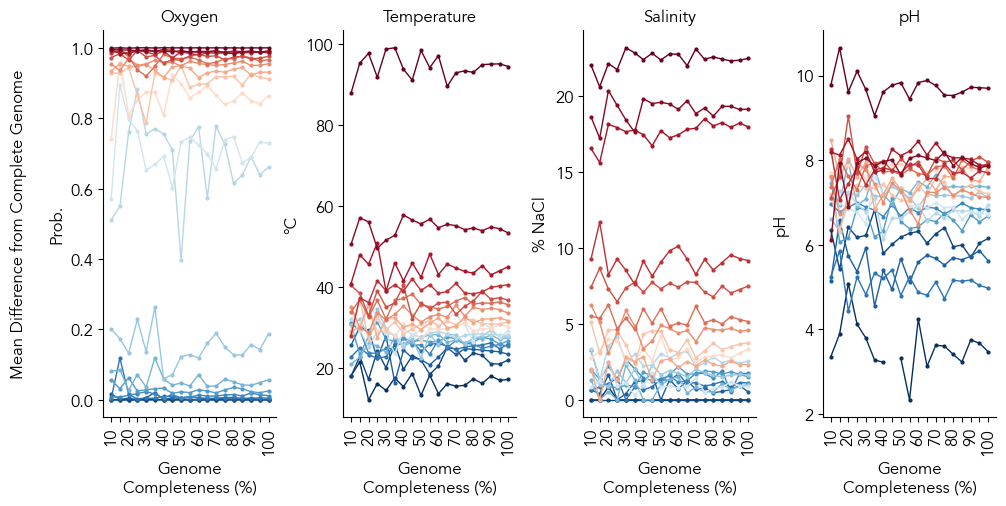

In [10]:
import matplotlib.pyplot as plt
N = 20


plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.RdBu_r(np.array(list(np.linspace(0,0.4,int(N/2))) + list(np.linspace(0.6,1,int(N/2))))))
targets =  [ 'oxygen', 'temperature_optimum', 'temperature_max', 'temperature_min', 'salinity_optimum', 'salinity_max', 'salinity_min', 'ph_optimum', 'ph_max', 'ph_min', ]
fig, axes = plt.subplots(1,4, figsize=(10,5))
axl = axes.flatten()
for n, condition in enumerate(['oxygen', 'temperature', 'salinity', 'ph']):
    target = rename_condition_to_variable(condition)
    genomes = genomes_to_test[target]
    ax = axl[n]
    for genome in genomes:
        filepath = glob(f"{ROOT_DIR}/data/subsample_experiment/{genome}*.predictions.json")[0]
        subsample_predictions = json.loads(open(filepath, 'r').read())


        if condition == 'oxygen':
            target = condition
        else:
            target = condition + '_optimum'

        data = pd.DataFrame(subsample_predictions)                

        Y = data.loc[target]
        X = 100 * subsample_portions[::-1]
        ax.plot(X, Y, label=genome, marker='o', markersize=2)
            
    #ax.legend(bbox_to_anchor=(1,1))
    
    ax.set_title(plot_formats[condition])
    ax.set_xticks(X)
    ax.set_xticklabels([f"{int(x)}" if n % 2 == 0 else '' for n, x in enumerate(X) ], rotation=90)
    ax.set_xlabel('Genome\nCompleteness (%)')
    if n == 0:
        ax.set_ylabel(f'Mean Difference from Complete Genome\n\n{units[condition]}')
    else:
        ax.set_ylabel(f'{units[condition]}')

plt.tight_layout(pad=0.4)

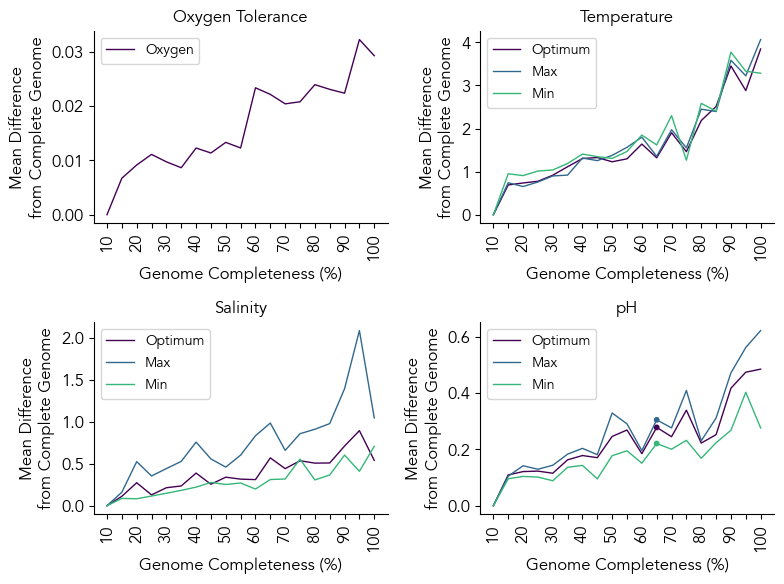

In [11]:
plot_formats = {
    'oxygen' : 'Oxygen Tolerance',
    'temperature' : 'Temperature',
    'ph' : 'pH',
    'salinity' : 'Salinity',
    'temperature_optimum' : 'Temperature, Optimum ',
    'ph_optimum' : 'pH, Optimum',
    'salinity_optimum' : 'Salinity, Optimum',
}


import matplotlib.pyplot as plt
N = 4
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))

targets =  [ 'oxygen', 'temperature_optimum', 'temperature_max', 'temperature_min', 'salinity_optimum', 'salinity_max', 'salinity_min', 'ph_optimum', 'ph_max', 'ph_min', ]

fig, axes = plt.subplots(2,2, figsize=(8,6))
axl = axes.flatten()
for n, condition in enumerate(['oxygen', 'temperature', 'salinity', 'ph']):
#for condition, genomes in genomes_to_test.items():
    target = rename_condition_to_variable(condition)
    genomes = genomes_to_test[target]
    ax = axl[n]
    for target in targets:
        
        if condition in target:
            
            diffs = []
            for genome in genomes:
                filepath = glob(f"{ROOT_DIR}/data/subsample_experiment/{genome}*.predictions.json")[0]
                subsample_predictions = json.loads(open(filepath, 'r').read())
                #print(genome)
                data = pd.DataFrame(subsample_predictions)                
                diff = np.abs(data.loc[target] - data.loc[target, '1.0'])
                diffs.append(diff)

            diffs = np.array(diffs)
            Y = np.nanmean(diffs, axis=0)
            X = 100 * subsample_portions

            S = (0 + 10 * np.sum(np.isnan(diffs),axis=0)) 
            ax.plot(X, Y, label=target.split('_')[-1].capitalize())
            ax.scatter(X, Y, s=S, clip_on=False)
                    
    ax.legend(fontsize=10)
    ax.set_title(plot_formats[condition])
    ax.set_xticks(X)
    ax.set_xticklabels([f"{int(x)}" if n % 2 == 0 else '' for n, x in enumerate(X) ], rotation=90)
    ax.set_xlabel('Genome Completeness (%)')
    ax.set_ylabel('Mean Difference\nfrom Complete Genome')

plt.tight_layout()

0.03227105188408997
3.8470847144661597
0.8930247076175799
0.484498626804835


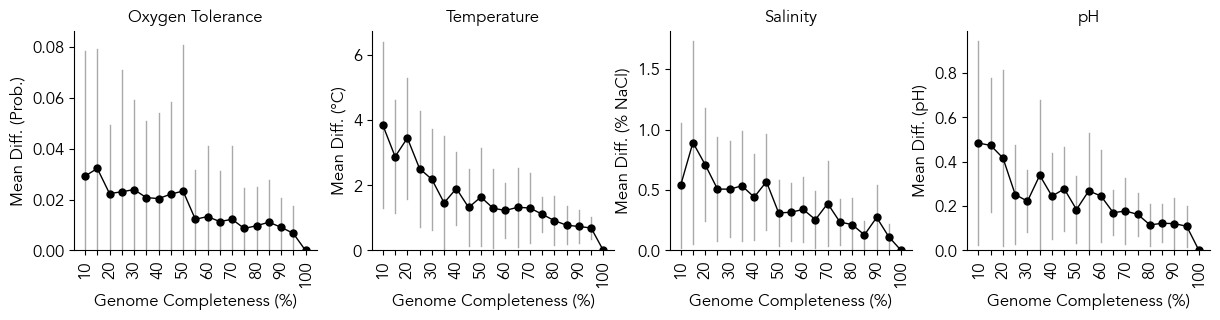

In [12]:

targets = ['oxygen', 'temperature_optimum', 'salinity_optimum', 'ph_optimum']

import matplotlib.pyplot as plt
N = 4
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))

fig, axes = plt.subplots(1,4, figsize=(12,3))
axl = axes.flatten()
for n, condition in enumerate(['oxygen', 'temperature', 'salinity', 'ph']):
    target = rename_condition_to_variable(condition)
    genomes = genomes_to_test[target]
    
    ax = axl[n]
    for target in targets:
        
        if condition in target:
            
            diffs = []
            for genome in genomes:
                filepath = glob(f"{ROOT_DIR}/data/subsample_experiment/{genome}*.predictions.json")[0]
                subsample_predictions = json.loads(open(filepath, 'r').read())
                #print(genome)
                data = pd.DataFrame(subsample_predictions)                
                diff = np.abs(data.loc[target] - data.loc[target, '1.0'])
                diffs.append(diff)

            diffs = np.array(diffs)
            Yerr = np.nanstd(diffs, axis=0) #/ np.nanmean(diffs, axis=0)
            Y = np.nanmean(diffs, axis=0)
            X = 100 * subsample_portions[::-1]
            print(Y.max())

            S = (0 + 10 * np.sum(np.isnan(diffs),axis=0)) 
            ax.plot(X, Y,  marker='.', color='black')
            #ax.errorbar(X, Y, Yerr, marker='.', color='black')
            #ax.scatter(X, Y, s=S, clip_on=False)
            for x, y, yerr in zip(X, Y, Yerr):
                ax.plot([x,x], [y-yerr, y+yerr], color='darkgray', zorder=0, lw=1, clip_on=True)
                    
            ax.set_title(plot_formats[condition])
    ax.set_xticks(X)
    ax.set_xticklabels([f"{int(x)}" if n % 2 == 0 else '' for n, x in enumerate(X) ], rotation=90)
    ax.set_xlabel('Genome Completeness (%)')
    #if n == 0:
    ax.set_ylabel(f'Mean Diff. ({units[condition]})')
    
    ax.set_ylim([0, ax.get_ylim()[1]])

plt.tight_layout(pad=0.)
plt.savefig("fig-2d.svg",  format="svg")
plt.show()